# 0. Imports & Installs

In [2]:
pip install spacy
pip install requests
pip install nltk
pip install gensim
pip install HanTa
nltk.download()
pip install top2vec

SyntaxError: invalid syntax (<ipython-input-2-7b30bcd2f8c3>, line 1)

In [45]:
import Top2Vec

ModuleNotFoundError: No module named 'Top2Vec'

In [43]:
import sklearn
import pandas as pd
import requests
import json
import urllib.parse
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
import re
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from HanTa import HanoverTagger as ht
#from top2vec import Top2Vec
from sklearn.datasets import fetch_20newsgroups


In [ ]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')
german_stop_words=stopwords.words('german')

# 0 Functions

In [4]:
#query für Top X Ergebnisse exact matching
def query2df(query,qlength):
    query=query.replace(' ', '%20')
    httpquery=('http://localhost:8983/solr/d115Services/select?indent=true&q.op=OR&q='+query+'&rows='+str(qlength))
    response = requests.get(httpquery)
    text = json.dumps(response.json()["response"]["docs"])
    text=text.replace('\'','')
    text=text.replace('/','')
    json_data = json.loads(text)
    df=pd.DataFrame.from_dict(json_data)
    return df

In [5]:
#query für Top X Ergebnisse ~matching
def query2dflex(query,qlength):
    query=query.replace(' ', '%20')
    httpquery=('http://localhost:8983/solr/d115Services/select?indent=true&q.op=OR&q=*'+query+'*&rows='+str(qlength))
    response = requests.get(httpquery)
    text = json.dumps(response.json()["response"]["docs"])
    text=text.replace('\'','')
    text=text.replace('/','')
    json_data = json.loads(text)
    df=pd.DataFrame.from_dict(json_data)
    return df

# 1 Fetching

In [12]:
df=query2dflex('%3A',1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            881 non-null    object 
 1   d115Url                       881 non-null    object 
 2   d115Name                      881 non-null    object 
 3   ssdsAll                       881 non-null    object 
 4   d115DocumentBoostValue        881 non-null    float64
 5   d115Description               881 non-null    object 
 6   d115Synonym                   881 non-null    object 
 7   d115Kennung                   99 non-null     object 
 8   d115Verrichtung               99 non-null     object 
 9   d115VerrichtungDetail         99 non-null     object 
 10  d115Position                  881 non-null    int64  
 11  d115InfoLaw                   881 non-null    object 
 12  d115Prerequisites             881 non-null    object 
 13  d115R

In [21]:
df['d115Description'][0]


'<ul class="list"><li>Sie geben eine Berliner Wohnung auf, weil Sie in das Ausland verziehen<li><ul><strong>oder<strong><br >\n<ul class="list"><li>Sie geben eine von mehreren Wohnungen in Deutschland auf, für die Sie angemeldet sind <strong>und<strong> die Berliner Wohnung bleibt bestehen<li><ul><strong>oder<strong><br >\n<ul class="list"><li>Sie geben eine von mehreren Berliner Wohnungen auf, für die Sie angemeldet sind<li><br >\n<ul>Sie müssen sich bei der Meldebehörde in Berlin nur bei einem Wegzug ins Ausland abmelden oder bei der Aufgabe einer Haupt- oder Nebenwohnung, ohne dass Sie in eine andere Wohnung im Inland einziehen.<br >\n<br >\nBeim Wegzug in das Ausland gilt, dass Sie aus dieser Wohnung ausziehen und dort zukünftig nicht wieder wohnen werden - befristete Auslandsaufenthalte, z.B. zu Studienzwecken bedingen keine Abmeldung.<br >\n<br >\nDie Abmeldung kann im Zeitraum von 7 Tagen vor, muss aber bis 14 Tage nach dem Auszug vorgenommen werden. Sie erhalten eine Abmeldebes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            74 non-null     object 
 1   d115Url                       74 non-null     object 
 2   d115Name                      74 non-null     object 
 3   ssdsAll                       74 non-null     object 
 4   d115DocumentBoostValue        74 non-null     float64
 5   d115Description               74 non-null     object 
 6   d115Synonym                   74 non-null     object 
 7   d115Kennung                   23 non-null     object 
 8   d115Verrichtung               23 non-null     object 
 9   d115VerrichtungDetail         23 non-null     object 
 10  d115Position                  74 non-null     int64  
 11  d115InfoLaw                   74 non-null     object 
 12  d115Prerequisites             74 non-null     object 
 13  d115Req

# 2 Preprocessing & Lemmatization

In [10]:
print(df['d115Name'])
print(df['ssdsLemma'][1])



0                  Personalausweis vorläufig beantragen
1                            Personalausweis beantragen
2     Verlust des Personalausweises melden (Verlusta...
3     Personalausweis, vorläufig, für Berliner Einwo...
4                               Personalausweis abholen
5     Personalausweis für in Berlin nicht gemeldete ...
6     Personalausweis - Befreiung von der Ausweispfl...
7     Online-Ausweisfunktion (eID) - nachträglich ak...
8     Online-Ausweisfunktion (eID) - PIN ändern  neu...
9              eID-Karte beantragen (EUEWR-Bürgerinnen)
10                eID-Karte abholen (EUEWR-Bürgerinnen)
Name: d115Name, dtype: object
['ausweisantrag', 'eid', 'beantragung', 'ausstellen', 'personalausweis', 'reisen', 'personaldokument', 'befreiung', 'epa', 'ausweis', 'personalausweiss', 'mit', 'personalausweiß', 'reise', 'verlängern', 'npa', 'neu', 'online-ausweisfunktion', 'perso', 'ausweispflicht', 'elektronisch', 'pass', 'ausstellung', 'identitätsnachweis', 'austellung', 'pa', 'pe

In [13]:
#Choose Column to be Clustered after
x=df['ssdsLemma']
y=[]
i=0;
while i<len(x):
    j = (' '.join([str(item)for item in x[i]])) #Joined alle einträge einer List in row i, column die oben gewählt wurde
    lemma = [lemma for (word,lemma,pos) in tagger.tag_sent(j.split())] #lemmatizer
    y.append(' '.join(lemma))
    i +=1          
df2 = pd.DataFrame(columns=['Name','Text','ClusterNo','ClusterName'])
df2['Name']=df['d115Name']
df2['Text']=y
k=round(math.sqrt(len(y))) #K = wurzel der Anzahl der Ergebnisse

In [16]:
y[1]

'Wohngeld Miete eigenheimhilfe lastenzuschuss Förderung Miete Wohnung -- zuschussen wohnhilf Eigenheim Wohneigentum wohnen Eigentumswohnung beantragen'

# 3.a.1 TfidfVectorizing & KMeans 

In [14]:
vectorizer2 = TfidfVectorizer(analyzer='word',stop_words=german_stop_words)
Y = vectorizer2.fit_transform(df2['Text'])
Kmodel = KMeans(n_clusters=k,init='k-means++',max_iter=100,n_init=1)
Kmodel.fit(Y)
df2['ClusterNo']=Kmodel.labels_
df2.info

<bound method DataFrame.info of                                                   Name  \
0                              Abmeldung einer Wohnung   
1                   Wohngeld - Mietzuschuss beantragen   
2    Adressänderung in der Zulassungsbescheinigung ...   
3                 Wohngeld - Lastenzuschuss beantragen   
4             Wohnberechtigungsschein (WBS) beantragen   
..                                                 ...   
876  Anerkennung ausländischer Berufsqualifikatione...   
877  Aufenthaltserlaubnis für die Teilnahme an eine...   
878  Aufenthaltsdokument-GB auf einen neuen Pass üb...   
879  Aufenthaltserlaubnis aus humanitären Gründen -...   
880  Aufenthaltserlaubnis zum vorübergehenden Schut...   

                                                  Text  ClusterNo ClusterName  
0    Umzug Wohnsitz Adressänderung ummelden Wegzug ...         26         NaN  
1    Wohngeld Miete mietzuschuss wohnhilfe lastenzu...         17         NaN  
2    Zbi anschriftenänderungen 

,Name
0,Wohngeld - Mietzuschuss beantragen


## 3.a.2 Show Cluster strongest Words

In [26]:
len(terms)

6171

In [32]:
liste=[]

In [33]:
liste[0][0]=0

IndexError: list index out of range

In [42]:
i_list=[]
for i in range(k):
    j_list=[]
    for j in order_centroids[i, :]:
        
        j_list.append(terms[j])
    i_list.append(j_list)

In [43]:
i_list

[['kfz',
  'anhänger',
  'kraftfahrzeug',
  'auto',
  'kennzeichen',
  'online',
  'fahrzeug',
  'kraftfahrzeugkennzeich',
  'zulassung',
  'reservierung',
  'abmelden',
  'beantragen',
  'halterauskunft',
  'setzen',
  'ikfz',
  'fahrzeugzulassung',
  'zuteilung',
  'kraftfahrzeugzulassung',
  'autozulassung',
  'sicherstellung',
  'kennzeich',
  'betreiben',
  'reservieren',
  'auskunft',
  'wunschkennzeich',
  'autostilllegung',
  'kraftfahrzeugstilllegung',
  'außerbetriebsetzung',
  'verwertungsnachweis',
  'fahrzeugstilllegung',
  'verschrotten',
  'wunschkenzeich',
  'lassen',
  'tüv',
  'wiederzulassung',
  'jahr',
  'grün',
  'außer',
  'dreharbeit',
  'altfahrzeug',
  'nummernschild',
  'umsetzung',
  'rot',
  'kennzeichenwechsel',
  'verbleibserklärung',
  'meldung',
  'steuerbefreit',
  'stillegung',
  'prüfungsfahrt',
  'überführungsfahrt',
  'händlerkennzeich',
  'kurzzeit',
  'inbetriebsetzung',
  'anmelden',
  'melden',
  'abweichung',
  'bauvorschrift',
  'abfragen',
 

In [32]:
terms[2393]

'glücksspiel'

In [27]:
order_centroids

array([[2393, 5827, 2350, ..., 4082, 4083,    0],
       [ 405, 2428, 2505, ..., 4097, 4098,    0],
       [4573, 4572, 2913, ..., 4050, 4051,    0],
       ...,
       [2352, 5543, 6107, ..., 4079, 4080,    0],
       [2148, 2750, 2744, ..., 4108, 4109,    0],
       [1246, 1649, 1642, ..., 4087, 4088,    0]], dtype=int64)

In [31]:
len(Kmodel.labels_)

881

In [36]:
print(Kmodel.cluster_centers_.shape)

(30, 6171)


In [41]:
Kmodel.cluster_centers_[1][1]

0.0

In [42]:
order_centroids[1]

array([ 405, 2428, 2505, ..., 4097, 4098,    0], dtype=int64)

In [15]:
m=5 #Top m Wörter die zum Clustering führten
order_centroids = Kmodel.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer2.get_feature_names()
for i in range(k):
    
    print("Cluster %d:" % i)
    #df2.iloc[i,3]=order_centroids[i,]
    for j in order_centroids[i, :5]: #print out 10 feature terms of each cluster
        
        print (' %s' % terms[j])
    print('------------')

Cluster 0:
 glücksspiel
 wetten
 gewinnmöglichkeit
 erlaubnis
 spielen
------------
Cluster 1:
 aufenthaltserlaubni
 grund
 gründen
 humanitär
 verlängerung
------------
Cluster 2:
 schulden
 schuld
 insolvenz
 beratung
 konkurs
------------
Cluster 3:
 bau
 ingenieur
 baukammer
 listen
 liste
------------
Cluster 4:
 namensrechtlich
 erklärung
 name
 namenserklärung
 nachname
------------
Cluster 5:
 berufserlaubnis
 ausbildung
 führen
 abschluß
 berufsbezeichnung
------------
Cluster 6:
 führerschein
 fahrerlaubnis
 lkw
 maut
 fahrgastbeförderung
------------
Cluster 7:
 aufenthaltserlaubni
 visum
 beschäftigung
 erwerbstätigkeit
 zweck
------------
Cluster 8:
 zulassung
 eu
 rechtsanwaltschaft
 zulassungsbescheinigung
 rechtsanwalt
------------
Cluster 9:
 ablegen
 prüfung
 berlin
 beruf
 berufserlaubnis
------------
Cluster 10:
 anerkennung
 berufsqualifikation
 ausländisch
 drittstaat
 gleichwertigkeit
------------
Cluster 11:
 behindern
 behinderung
 schwerbehinderung
 schwerbehi

# 3.b.1 CountVectorier KMeans Plot with Name

In [351]:
print(kmean_indices)

[2 2 4 2 2 2 4 2 2 2 2 3 4 2 0 0 0 0 1 4]


In [33]:
df2.iloc[1,0].partition('-')[0]

'Wohngeld '

In [9]:
y=df2['Text']
cv = CountVectorizer(analyzer = 'word', max_features = 5000, lowercase=True, preprocessor=None, tokenizer=None, stop_words = 'english')  
vectors = cv.fit_transform(y)
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
kmean_indices = kmeans.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

colors = ["red", "blue", "c", "y", "m" ,"g","o"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))
plt.axis([-0.83,-0.575,-0.7,-0.075])    #current window-optimization

ab=ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices],label=k)
#plt.legend(handles=ab.legend_elements()[0], labels=[0,1,2,3,4])
for i, txt in enumerate(y):
    ax.annotate(df2.iloc[i,0].partition('-')[0], (x_axis[i], y_axis[i]))
plt.savefig('query_antrag2.png',dpi=60
           )

## 3.b.2 CountVectorizer Kmeans show strongest Topc words

In [10]:
m=10 #Top m Wörter die zum Clustering führten
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i)
    #df2.iloc[i,3]=order_centroids[i,]
    for j in order_centroids[i, ]: #print out m feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster 0:
 auf
 antrag
 zulassung
 rechtsanwaltschaft
 rechtsanwaltsverzeichnis
 rechtsanwalt
 rechtsanwältin
 angehörige
 der
 erteilung
 aufnahme
 zur
 tätigkeit
 befreiung
 brao
 mitgliedstaat
 nach
 206
 deutschland
 für
 ein
 welthandelsorganisation
 europäisch
 eurag
 von
 bundesrechtsanwaltsordnung
 eu
 kanzleipflicht
 anwalt
 kanzleipflichtbefreiung
 kanzleisitz
 als
 gerber
 fliesenleger
 folgesache
 fotograf
 freizügigkeit
 freizügigkeitsrecht
 freudenhaus
 friseur
 fuger
 förderprogramm
 förderung
 geschäftsbetrieb
 fleischzerleger
 galvaniseure
 gang
 gebäudereiniger
 gerüstbauer
 geigenbauer
 flexografen
 fleisch
 fleischer
 keim
 klavierstimmer
 klavierbauer
 ewr
 fahrzeugbauer
 fahrzeugverwert
 familienangehörig
 keramiker
 feinoptiker
 keimen
 feintäschner
 getränkeleitungsreiniger
 feinwerkmechaniker
 festsetzung
 feststellung
 finanzamt
 firmeninsolvenz
 firmenpleit
 flechtwerkgestalter
 karosseriebauer
 fleckteppichherstell
 gesundheitsamt
 informationstechniker
 in

 finanzamt
 folgesache
 firmeninsolvenz
 firmenpleit
 flechtwerkgestalter
 fleckteppichherstell
 fleisch
 fleischer
 fleischzerleger
 fliesenleger
 flexografen
 gesundheitsamt
 geigenbauer
 hinterbliebenenrent
 holz
 holzbildhauer
 holzblasinstrumentenmacher
 holzblockmach
 holzimprägnierung
 holzreifenmacher
 holzschindelmacher
 holzschuhmacher
 holzspielzeugmacher
 hwk
 hörakustiker
 im
 inbesitznahm
 infektionserreger
 infektionserregerdiagnostik
 infektionsschutzgesetz
 informationstechniker
 innerei
 insolvenz
 insolvenzverfahren
 installateur
 juristisch
 kabelverleger
 kanalreiniger
 kanzleipflicht
 hochzeit
 heizungsbauer
 gerber
 heiratsgenehmigung
 gerüstbauer
 geschäftsbetrieb
 eurag
 getränkeleitungsreiniger
 gewerbe
 glasanmaler
 glasapparatebauer
 glasbläser
 glaser
 glasveredl
 glockengießer
 goldschmied
 graveure
 grundbuchbereinigung
 grundstück
 grundstücksbereinigung
 handdrucker
 handschuhmacher
 handwerk
 handwerkskammer
 handwerksrolle
 handwerksähnlich
 handzugin

In [16]:
print(' %s'% terms[j])

 206


In [17]:
for i in range(k):
    print("Cluster %d:" % i)
    #df2.iloc[i,3]=order_centroids[i,]
    for j in order_centroids[i, ]: #print out m feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster 0:
 eu
 deutschland
 bürger
 europäisch
 anwalt
 eurag
 tätigkeit
 aufnahme
 antrag
 einstweilig
 vollstreckungsschutz
 vollstreckungsschutzantrag
 räumungsschutzantrag
 räumungsschutz
 inbesitznahm
 räumung
 einstellung
 spezialfall
 zwangsvollstreckung
 wohnungsräumung
 zwangsräumung
 maßnahme
 rent
 sozialversicherung
 altersrent
 waisenrent
 versicherung
 hinterbliebenenrent
 schwerbehindertenrent
 drv
 witwenrent
 erwerbsminderungsrent
 rentenantrag
 rente
 stellen
 rechtsanwalt
 rechtsanwältin
 aufenthaltskart
 freizügigkeit
 antragsbescheinigung
 freizügigkeitsrecht
 einreichung
 familienangehörig
 ewr
 außer
 rechtsanwaltschaft
 zulassung
 rechtsanwaltsverzeichnis
 bescheinigung
 ausstellung
 fliesenleger
 fuger
 erteilung
 förderung
 friseur
 freudenhaus
 gang
 förderprogramm
 fotograf
 folgesache
 galvaniseure
 fahrzeugverwert
 flexografen
 finanzamt
 gebäudereiniger
 feinoptiker
 feintäschner
 feinwerkmechaniker
 festsetzung
 feststellung
 firmeninsolvenz
 estrichleg

#  Extra: Text als Label

In [359]:
print(Y)

  (0, 29)	0.24381585697418307
  (0, 423)	0.2702024005700061
  (0, 145)	0.2702024005700061
  (0, 418)	0.2702024005700061
  (0, 420)	0.30739214500037704
  (0, 231)	0.2702024005700061
  (0, 422)	0.30739214500037704
  (0, 262)	0.30739214500037704
  (0, 261)	0.5404048011400122
  (0, 419)	0.2702024005700061
  (1, 92)	0.27363077881084974
  (1, 417)	0.27363077881084974
  (1, 90)	0.27363077881084974
  (1, 421)	0.27363077881084974
  (1, 433)	0.24052564291921408
  (1, 91)	0.27363077881084974
  (1, 29)	0.21703717520237428
  (1, 423)	0.24052564291921408
  (1, 145)	0.24052564291921408
  (1, 418)	0.24052564291921408
  (1, 231)	0.24052564291921408
  (1, 261)	0.48105128583842816
  (1, 419)	0.24052564291921408
  (2, 176)	0.3033015430071928
  (2, 5)	0.1490207814871882
  :	:
  (18, 266)	0.06884054358299853
  (18, 437)	0.06884054358299853
  (18, 182)	0.06884054358299853
  (18, 285)	0.06884054358299853
  (18, 268)	0.06884054358299853
  (18, 5)	0.03382334128942428
  (19, 404)	0.20565860311830478
  (19, 403)	

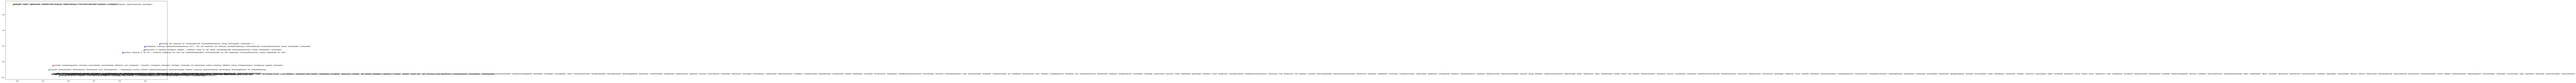

In [363]:
kmean_indices = Kmodel.labels_

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(Y.toarray())

colors = ["r", "b", "c", "y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmean_indices])

for i, txt in enumerate(x):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

In [ ]:
i=0
while i<len(x):
    ax.annotate(df2.iloc[i,0], (x_axis[i], y_axis[i]))
    i=+1

In [130]:
terms

['00',
 '01',
 '07',
 '0ahukewiaw4odg83vahwbbhqkhxvldkuqfggmmaa',
 '0ahukewjzloqrg83vahuh6xqkhamfc4uqfgg1mam',
 '10',
 '100',
 '10000',
 '11',
 '12',
 '13',
 '130',
 '14',
 '15',
 '16',
 '16999',
 '1951',
 '1954',
 '1g',
 '20',
 '200',
 '2011',
 '22',
 '23',
 '24',
 '25',
 '27',
 '28',
 '2f',
 '2f02',
 '2f2017',
 '2f27',
 '2fdach',
 '2fde_unhcr',
 '2fsites',
 '2fuploads',
 '2fwp',
 '2fwww',
 '350',
 '35mm',
 '37',
 '38',
 '3a',
 '40',
 '45',
 '45mm',
 '46',
 '47',
 '50',
 '60',
 '70',
 '80',
 '97',
 '__blob',
 'ab',
 'abfrage',
 'abfragen',
 'abgabe',
 'abgeben',
 'abgelaufen',
 'abgelehnt',
 'abgibt',
 'abholen',
 'abholt',
 'abholung',
 'abkommens',
 'ablauf',
 'abläuft',
 'ablösen',
 'abs',
 'abschnitt',
 'absoluten',
 'abstimmung',
 'abweichen',
 'abwicklung',
 'abzuholen',
 'abzurufen',
 'abzustellen',
 'achtung',
 'afqjcng6voxvksg7ovtexkxicnnxsl9',
 'afqjcnghra03curze3eth5bp4ne7zwtlcw',
 'ag',
 'akte',
 'aktuell',
 'aktuelle',
 'aktuelles',
 'alleine',
 'allgemeine',
 'alt',
 'al

# DBSCAN (not working atm)

In [76]:
vectorizer = TfidfVectorizer(analyzer='word',stop_words=german_stop_words)
X = vectorizer.fit_transform(y)
#TfidfVectorizer.fit_transform(df.iloc[:,3])
#vectorizer.get_feature_names()
X=X.todense()
db = DBSCAN(eps=0.3,min_samples=10).fit(X)

NameError: name 'DBSCAN' is not defined

In [73]:
print(X)

  (0, 794)	0.02024627037125195
  (0, 792)	0.02024627037125195
  (0, 212)	0.02722262693542649
  (0, 502)	0.02722262693542649
  (0, 951)	0.0180003851932923
  (0, 209)	0.02722262693542649
  (0, 1029)	0.02722262693542649
  (0, 662)	0.023141719953724497
  (0, 243)	0.02722262693542649
  (0, 57)	0.02722262693542649
  (0, 991)	0.02722262693542649
  (0, 1083)	0.014613874561136763
  (0, 206)	0.014613874561136763
  (0, 901)	0.023141719953724497
  (0, 258)	0.02722262693542649
  (0, 1005)	0.02722262693542649
  (0, 5)	0.029227749122273525
  (0, 465)	0.04384162368341029
  (0, 43)	0.023141719953724497
  (0, 19)	0.0694251598611735
  (0, 1061)	0.0180003851932923
  (0, 1078)	0.02722262693542649
  (0, 780)	0.023141719953724497
  (0, 460)	0.048496090168649884
  (0, 459)	0.02024627037125195
  :	:
  (9, 560)	0.051571050293413
  (9, 778)	0.028523057485068847
  (9, 548)	0.017758808079406673
  (9, 777)	0.017758808079406673
  (9, 368)	0.10655284847644003
  (9, 640)	0.035517616158813346
  (9, 1095)	0.017758808079

In [56]:
df.info

<bound method DataFrame.info of        id                                      d115Url  \
0  121721  https:service.berlin.dedienstleistung121721   
1  328493  https:service.berlin.dedienstleistung328493   
2  326523  https:service.berlin.dedienstleistung326523   
3  120726  https:service.berlin.dedienstleistung120726   
4  121737  https:service.berlin.dedienstleistung121737   
5  325471  https:service.berlin.dedienstleistung325471   
6  326439  https:service.berlin.dedienstleistung326439   
7  120682  https:service.berlin.dedienstleistung120682   
8  120703  https:service.berlin.dedienstleistung120703   
9  324325  https:service.berlin.dedienstleistung324325   

                                            d115Name  \
0  Parkausweis für Anwohner beantragen, umschreib...   
1                   Parkausweis für Gäste beantragen   
2  Handwerkerparkausweis - Ausnahmegenehmigung Pa...   
3  Verlust des Personalausweises melden (Verlusta...   
4                           Schwerbehindertenausw

In [58]:
print(x)

0    [Parkausweis für Anwohner beantragen, umschrei...
1    [Parkausweis für Gäste beantragen, In Berlin w...
2    [Handwerkerparkausweis - Ausnahmegenehmigung P...
3    [Verlust des Personalausweises melden (Verlust...
4    [Schwerbehindertenausweis, Mit einem Schwerbeh...
5    [Reiseausweis - Neuausstellung, Durch eine Aus...
6    [Parkausweis für Schwerbehinderte Ausstellung,...
7    [Personalausweis vorläufig beantragen, Ihr Per...
8    [Personalausweis beantragen, Mit einem Persona...
9    [Personalausweis abholen, Wenn Ihr neuer Perso...
Name: ssdsAll, dtype: object


In [55]:
documents = x.values.astype('U')

ValueError: setting an array element with a sequence

In [64]:
df

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Position,d115InfoLaw,d115Prerequisites,...,ssdsManualKeywords,_version_,d115Forms,ssdsVerrichtung,ssdsVerrichtungDict,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict,d115Kennung,d115Verrichtung,d115VerrichtungDetail
0,121925,https://service.berlin.de/dienstleistung/121925/,Haus- und Nachbarschaftslärm,"[Haus- und Nachbarschaftslärm, Haus- und Nachb...",1.000000,Haus- und Nachbarschaftslärm<br />\n<br />\nAl...,"[Tierlärm, Lärmanzeige, Lärmschutz, Nachbarsch...",101,"[{""name"":""Landes-Immissionsschutzgesetz Berlin...","[{""name"":""keine Voraussetzungen erforderlich"",...",...,"[beschwerde, belästigung, Ruhestörung, Lärm vo...",1727918339893755904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,327970,https://service.berlin.de/dienstleistung/327970/,Schaustellung von Personen - Erlaubnis beantragen,[Schaustellung von Personen - Erlaubnis beantr...,1.000000,Wenn Sie gewerbsmäßig Schaustellungen von Pers...,"[Pole Dance, Peep-Show, Striptease-Veranstaltu...",101,"[{""name"":""Verwaltungsgebührenordnung (VGebO)"",...","[{""name"":""persönliche Zuverlässigkeit"",""link"":...",...,NaN,1727918342106251264,"[{""name"":""Antrag auf Erteilung einer Erlaubnis...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,328951,https://service.berlin.de/dienstleistung/328951/,Hausbrunnen und kleine Wasserwerke - Überwachung,[Hausbrunnen und kleine Wasserwerke - Überwach...,1.000000,Betreiberinnen und Betreiber von Hausbrunnen m...,"[§ 14 TrinkWV, Kleinanlage, Brunnen, Wasserwer...",101,"[{""name"":""Trinkwasserverordnung (TrinkwV) § 14...","[{""name"":""Die Probeentnahme muss von einer zug...",...,NaN,1727918342451232768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,326043,https://service.berlin.de/dienstleistung/326043/,Telefonische Fachauskunft in KFZ-Angelegenheiten,[Telefonische Fachauskunft in KFZ-Angelegenhei...,1.000000,Für telefonische Auskünfte steht Ihnen das Ser...,"[Service-Telefon, Kraftfahrzeug, KFZ, Auskunft]",101,"[{""name"":""-"",""link"":"""",""description"":null}]","[{""name"":""Kein Voraussetzungen erforderlich."",...",...,NaN,1727918341115346944,NaN,[Auskunft],[Auskunft],[Telefonische Fachauskunft in KFZ-Angelegenhei...,[Telefonische Fachauskunft in KFZ-Angelegenhei...,NaN,NaN,NaN
4,121921,https://service.berlin.de/dienstleistung/121921/,Gewerbe anmelden,"[Gewerbe anmelden, Eine Gewerbeanmeldung ist i...",1.265070,Eine Gewerbeanmeldung ist immer dann notwendig...,"[GewA1, Geschäftseröffnung, Gewerbeschein, Bet...",10,"[{""name"":""Gewerbeordnung (GewO) § 14 Abs. 1 - ...","[{""name"":""Die Gewerbeanmeldung ist gleichzeiti...",...,"[selbständige Arbeit, Nebengewerbe, Untehrnehm...",1727918339886415872,"[{""name"":""Gewerbeanmeldung"",""link"":""https://ww...","[Anmeldung, anmelden]","[Anmeldung, anmelden]",NaN,NaN,Gewerbe,anmelden,
5,122111,https://service.berlin.de/dienstleistung/122111/,Gewerbe ummelden,"[Gewerbe ummelden, Eine Gewerbeummeldung ist i...",1.181824,Eine Gewerbeummeldung ist immer dann notwendig...,"[Betriebssitzverlegung, Ausdehnung, Gewerbesch...",77,"[{""name"":""Gewerbeanzeigeverordnung (GewAnzV)"",...","[{""name"":""Die Gewerbeummeldung ist gleichzeiti...",...,NaN,1727918339903193088,"[{""name"":""Gewerbeummeldung"",""link"":""https://ww...","[ummelden, Ummeldung]","[ummelden, Ummeldung]",NaN,NaN,Gewerbe,ummelden,
6,120686,https://service.berlin.de/dienstleistung/120686/,Anmeldung einer Wohnung,"[Anmeldung einer Wohnung, Melden Sie sich inne...",2.000000,Melden Sie sich innerhalb von <strong>14 Tagen...,"[wohnsitz, ummelden, Wohnung, anmelden, Wohnun...",17,"[{""name"":""Bundesmeldegesetz (BMG)"",""link"":""htt...","[{""name"":""Persönliches Erscheinen (Vertretung ...",...,"[Adresse, Anmeldepflicht, Ummeldung Wohnsitz, ...",1727918339484811264,"[{""name"":""Anmeldeformular"",""link"":""https://www...","[Anmeldung, anmelden]","[Anmeldung, anmelden]",NaN,NaN,Wohnsitz,anmelden,
7,328945,https://service.berlin.de/dienstleistung/328945/,Trinkwasserinstallation anmelden - u

http://localhost:8983/solr/d115Services/select?indent=true&q.op=OR&q=Haus%20bauen


AttributeError: 'dict' object has no attribute 'dumps'

[{"id": "121925", "d115Url": "https://service.berlin.de/dienstleistung/121925/", "d115Name": "Haus- und Nachbarschaftsl\u00e4rm", "ssdsAll": ["Haus- und Nachbarschaftsl\u00e4rm", "Haus- und Nachbarschaftsl\u00e4rm<br />\n<br />\nAllgemeine Informationen<br />\n<br />\nBei Haus- und Nachbarschaftsl\u00e4rm handelt es sich um sogenannten verhaltensbedingten L\u00e4rm, da er durch das menschliche Verhalten unmittelbar verursacht wird. Hierzu z\u00e4hlt neben lauten Gespr\u00e4chen u.a. auch das Spielen von Instrumenten oder Gesang (Hausmusik) bzw. Abspielen von lauter Musik mittels Tonwiedergabeger\u00e4ten. Tierl\u00e4rm wird in der Regel ebenso unter Haus-und Nachbarschaftsl\u00e4rm erfasst. Im Interesse eines guten nachbarschaftlichen Verh\u00e4ltnisses kann oftmals ein Gespr\u00e4ch mit dem L\u00e4rmverursacher schnell Abhilfe schaffen und dadurch \u00c4rger vermieden werden. Gleichfalls sollten der Vermieter oder die zust\u00e4ndige Hausverwaltung \u00fcber die L\u00e4rmst\u00f6runge

In [46]:
json_data

[{'id': '121925',
  'd115Url': 'https://service.berlin.de/dienstleistung/121925/',
  'd115Name': 'Haus- und Nachbarschaftslärm',
  'ssdsAll': ['Haus- und Nachbarschaftslärm',
   'Haus- und Nachbarschaftslärm<br />\n<br />\nAllgemeine Informationen<br />\n<br />\nBei Haus- und Nachbarschaftslärm handelt es sich um sogenannten verhaltensbedingten Lärm, da er durch das menschliche Verhalten unmittelbar verursacht wird. Hierzu zählt neben lauten Gesprächen u.a. auch das Spielen von Instrumenten oder Gesang (Hausmusik) bzw. Abspielen von lauter Musik mittels Tonwiedergabegeräten. Tierlärm wird in der Regel ebenso unter Haus-und Nachbarschaftslärm erfasst. Im Interesse eines guten nachbarschaftlichen Verhältnisses kann oftmals ein Gespräch mit dem Lärmverursacher schnell Abhilfe schaffen und dadurch Ärger vermieden werden. Gleichfalls sollten der Vermieter oder die zuständige Hausverwaltung über die Lärmstörungen informiert werden. Zur Schlichtung kann auch die für den jeweiligen Wohnbereich

In [34]:
data=response.json()


In [37]:
type(data)

dict

In [30]:
data = data[]

In [48]:
df

,id,d115Url,d115Name,ssdsAll,d115DocumentBoostValue,d115Description,d115Synonym,d115Position,d115InfoLaw,d115Prerequisites,...,ssdsKennungDict,ssdsSynonym,ssdsSynonymDict,ssdsManualKeywords,_version_,d115Forms,ssdsVerrichtung,ssdsVerrichtungDict,ssdsVerrichtungDetail,ssdsVerrichtungDetailDict
0,121925,https://service.berlin.de/dienstleistung/121925/,Haus- und Nachbarschaftslärm,"[Haus- und Nachbarschaftslärm, Haus- und Nachb...",1.0,Haus- und Nachbarschaftslärm<br />\n<br />\nAl...,"[Tierlärm, Lärmanzeige, Lärmschutz, Nachbarsch...",101,"[{""name"":""Landes-Immissionsschutzgesetz Berlin...","[{""name"":""keine Voraussetzungen erforderlich"",...",...,[Lärmschutz],"[Tierlärm, Fluglärm, Lärmanzeige, Schallschutz...","[Tierlärm, Fluglärm, Lärmanzeige, Schallschutz...","[beschwerde, belästigung, Ruhestörung, Lärm vo...",1727918339893755904,NaN,NaN,NaN,NaN,NaN
1,327970,https://service.berlin.de/dienstleistung/327970/,Schaustellung von Personen - Erlaubnis beantragen,[Schaustellung von Personen - Erlaubnis beantr...,1.0,Wenn Sie gewerbsmäßig Schaustellungen von Pers...,"[Pole Dance, Peep-Show, Striptease-Veranstaltu...",101,"[{""name"":""Verwaltungsgebührenordnung (VGebO)"",...","[{""name"":""persönliche Zuverlässigkeit"",""link"":...",...,[Erlaubnis zur gewerbsmäßigen Schaustellung vo...,"[Pole Dance, Peep-Show, Striptease-Veranstaltu...","[Pole Dance, Peep-Show, Striptease-Veranstaltu...",NaN,1727918342106251264,"[{""name"":""Antrag auf Erteilung einer Erlaubnis...",NaN,NaN,NaN,NaN
2,328951,https://service.berlin.de/dienstleistung/328951/,Hausbrunnen und kleine Wasserwerke - Überwachung,[Hausbrunnen und kleine Wasserwerke - Überwach...,1.0,Betreiberinnen und Betreiber von Hausbrunnen m...,"[§ 14 TrinkWV, Kleinanlage, Brunnen, Wasserwer...",101,"[{""name"":""Trinkwasserverordnung (TrinkwV) § 14...","[{""name"":""Die Probeentnahme muss von einer zug...",...,[Hausbrunnen und kleine Wasserwerke - Überwach...,"[§ 14 TrinkWV, Kleinanlage, Brunnen, Wasserwer...","[§ 14 TrinkWV, Kleinanlage, Brunnen, Wasserwer...",NaN,1727918342451232768,NaN,NaN,NaN,NaN,NaN
3,326043,https://service.berlin.de/dienstleistung/326043/,Telefonische Fachauskunft in KFZ-Angelegenheiten,[Telefonische Fachauskunft in KFZ-Angelegenhei...,1.0,Für telefonische Auskünfte steht Ihnen das Ser...,"[Service-Telefon, Kraftfahrzeug, KFZ, Auskunft]",101,"[{""name"":""-"",""link"":"""",""description"":null}]","[{""name"":""Kein Voraussetzungen erforderlich."",...",...,[Kraftfahrzeug],"[Service-Telefon, Kraftfahrzeug, KFZ, Auskunft]","[Service-Telefon, Kraftfahrzeug, KFZ, Auskunft]",NaN,1727918341115346944,NaN,[Auskunft],[Auskunft],[Telefonische Fachauskunft in KFZ-Angelegenhei...,[Telefonische Fachauskunft in KFZ-Angelegenhei...


In [ ]:
text = json.dumps(http)